In [1]:
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from astropy.io import fits
import tqdm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError
from scipy.optimize import fmin, minimize


A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
path = '/Users/dhortadarrington/Documents/Projects/mw-bar/data/table_centroids.fits'
tb = fits.open(path)
data = tb[1].data 

In [3]:
data

FITS_rec([('disc', 0. , 1. , 0.7 , 0.3 , 0.92, 1.596e-01, -0.0258, 2.62e-02,  1.800e+00,  -12.7,  12.4,  9.300e+00,  -12.3,  12. , -9.280e+01,   -9.5,  10.1, 24.2, -54. , 16.5, 130.4, -10.4, 14.1, 142.3, -14.4, 13.7,  41.7,  -6.2,  6.3),
          ('bar', 0. , 1. , 0.7 , 0.3 , 0.92, 6.136e-01, -0.0274, 2.86e-02,  2.500e+00,   -3.1,   3.2,  2.200e+00,   -2.5,   2.4, -1.170e+01,   -2.8,   2.8, 38.8,  -3.6,  3.6,  80.3,  -2.8,  3. ,  55.7,  -2.8,  3. ,  30.8,  -2.2,  2.5),
          ('knot', 0. , 1. , 0.7 , 0.3 , 0.92, 2.274e-01, -0.0203, 2.07e-02, -7.000e-01,   -1. ,   2.3, -8.000e-01,   -0.9,   1.5,  0.000e+00,   -0.8,   0.8, 33.5,  -4.3,  5.1,  25.8,  -2.6,  2.8,  10.5,  -0.4,  0.9,  10.1,  -0.1,  0.2),
          ('disc', 0.5, 1.5, 1.02, 0.7 , 1.38, 1.872e-01, -0.0212, 2.07e-02, -3.700e+00,  -10.1,  10. ,  9.300e+00,  -10.4,  10.7, -1.171e+02,   -7.7,   7.9, 31.6, -13.3, 12.4, 150.3,  -7.3,  8.4, 173.8,  -9.2, 10.4,  69.4,  -6. ,  6.3),
          ('bar', 0.5, 1.5, 1.02, 0.7 , 1.38, 6.1

In [4]:
mask_disc = np.where(data['comp']=='disc')
mask_knot = np.where(data['comp']=='knot')
mask_bar = np.where(data['comp']=='bar')


In [5]:
lz = data['Lz']
lz_min = (data['Lz-'])
lz_max = (data['Lz+'])

angle = 90 - data['alpha']
angle_min = (data['alpha-'])
angle_max = (data['alpha+'])

In [6]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
# f.keys() # this would list all the APOGEE IDs, including doubles for half-integer bins
median_knot_probability = []
median_bar_probability = []
median_disc_probability = []
std_knot_probability = []
std_bar_probability = []
std_disc_probability = []
all_knot_probability = []
all_bar_probability = []
all_disc_probability = []
RxyzL = []


for key in tqdm.tqdm_notebook(f.keys()):
    median_knot_probability.append(np.nanmedian(f[key][:,2]))
    median_bar_probability.append(np.nanmedian(f[key][:,1]))
    median_disc_probability.append(np.nanmedian(f[key][:,0]))
    std_knot_probability.append(np.nanstd(f[key][:,2]))
    std_bar_probability.append(np.nanstd(f[key][:,1]))
    std_disc_probability.append(np.nanstd(f[key][:,0]))
    all_knot_probability.append((f[key][:,2]))
    all_bar_probability.append((f[key][:,1]))
    all_disc_probability.append((f[key][:,0]))
    RxyzL.append(f[key][:,3][:7])
f.close() # don't forget to close the file!



  0%|          | 0/32489 [00:00<?, ?it/s]

In [7]:
np.shape(RxyzL)

(32489, 7)

In [8]:
mask_knot2 = (np.array(median_knot_probability)>0.8)&(np.array(std_knot_probability)<0.15)
mask_bar2 = (np.array(median_bar_probability)>0.8)&(np.array(std_bar_probability)<0.15)
mask_disc2 = (np.array(median_disc_probability)>0.8)&(np.array(std_disc_probability)<0.15)
RxyzL_ = np.array(RxyzL)
R = RxyzL_[:,0]
x = RxyzL_[:,1]
y = RxyzL_[:,2]
z = RxyzL_[:,3]
Lx = RxyzL_[:,4]
Ly = RxyzL_[:,5]
Lz = RxyzL_[:,6]*-1


In [9]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
apo_ids = []
apo_ids2 = []
apo_ids3 = []
for key in tqdm.tqdm_notebook(f.keys()):
    new_key = key.replace("*", "")
    apo_ids.append(new_key)
    apo_ids3.append(key)
    if '*' in key:
        pass
    else:
        apo_ids2.append(key)
f.close() # don't forget to close the file!


  0%|          | 0/32489 [00:00<?, ?it/s]

# fit the data weighted by the probability

let our function be y = mx + b. The linear regression is fitted by finding the derivative of a chi squared function for all possible parameter values (in this case m and x). This is referred to as a "loss function"

This loss function can also be weighted, such that $\chi^{2} = \Sigma_{i=1}^{n} \omega_{i}*\epsilon_{i}^{2}$, where $\epsilon_{i} = y_{i} - (x_{i}m + b)$


In [10]:
#### for linear model with no intercept, the b in above equation drops out. The derivative of the chi2 w.r.t. m gives you the solution for m
# this yields m = (Sum_i=1^n w_i*(y_i - yhat)*(x_i - xhat))/(Sum_i=1^n w_i*(x_i - xhat)**2)
# where yhat = (Sum_i=1^n w_i*y_i)/(Sum_i=1^n w_i) and xhat = (Sum_i=1^n w_i*x_i)/(Sum_i=1^n w_i)

XS = R**2
YS = Lz
weights = np.array(median_bar_probability)

yhat = (np.sum(weights*YS))/(np.sum(weights))
xhat = (np.sum(weights*XS))/(np.sum(weights))

slope = (np.sum(weights*(YS - yhat)*(XS-xhat)))/(np.sum(weights*(XS-xhat)**2))
print(slope)


23.077210676118444


In [11]:
def linear(xs,m):
    return m*xs

In [12]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,R**2,Lz) 
popt

array([39.64348562])

In [13]:
def loss(w):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(linear,XS,YS)     
    ypred = linear(XS,w)
    # here we will use a weighted least squares
    return np.sum(weights*(YS-ypred)**2)
    

In [14]:
from scipy.optimize import fmin, minimize

res = minimize(loss, popt, method='nelder-mead')


In [15]:
print(res['x'])

[23.89152746]


# Now do the same bootstrapping to get the errors

In [16]:
XS = R**2
YS = Lz
weights = np.array(all_bar_probability)


In [17]:
def loss(w):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(linear,XS,YS)     
    ypred = linear(XS,w)
    # here we will use a weighted least squares
    return np.sum(weights*(YS-ypred)**2)

In [18]:
res = []
for indx, i in tqdm.tqdm_notebook(enumerate(weights.T)):
    def loss2(w):
        popt, pcov = curve_fit(linear,XS,YS)     
        ypred = linear(XS,w)
        # here we will use a weighted least squares
        return np.sum(i*(YS-ypred)**2)

    res.append(minimize(loss2, popt, method='nelder-mead'))

    
    

0it [00:00, ?it/s]

In [19]:
slopes = []
for indx, i in enumerate(res):
    slopes.append(i['x'])
slopes = np.array(slopes).T[0]

In [20]:
print(np.mean(slopes))
print(np.std(slopes))

24.10113688648928
0.8923343264068501


In [21]:
XS = R**2
YS = Lz
weights2 = np.array(all_disc_probability)

In [22]:
res_disc = []
for indx, i in tqdm.tqdm_notebook(enumerate(weights2.T)):
    def loss2(w):
        popt, pcov = curve_fit(linear,XS,YS)     
        ypred = linear(XS,w)
        # here we will use a weighted least squares
        return np.sum(i*(YS-ypred)**2)

    res_disc.append(minimize(loss2, popt, method='nelder-mead'))

    
    

0it [00:00, ?it/s]

In [23]:
slopes_disc = []
for indx, i in enumerate(res_disc):
    slopes_disc.append(i['x'])
slopes_disc = np.array(slopes_disc).T[0]

In [24]:
print(np.nanmean(slopes_disc))

41.0322820893563


In [25]:
def chi2(y_pred, y_true,weights):
    return jnp.sum(jnp.dot(weights,(y_true - y_pred)**2))

# Make the angle and L$_{z}$ vs $R$ plot for the paper

In [26]:
radios = np.linspace(0,100,101)


In [27]:
# fit the whole thing without any weights
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,R**2,Lz) 
popt

array([39.64348562])

In [28]:
# get also the scatter of the stars with high bar and disc probability
radios2 = np.linspace(0,25,8)
scatter_bar = np.zeros((len(radios2[:-1])))
for indx, i in enumerate(radios2[:-1]):
#     mascara = (R**2>i)&(R**2<radios2[indx+1])&(np.array(median_bar_probability)>0.8)
#     scatter_bar[indx] = np.nanstd(Lz[mascara])
    mascara = ((data['binmin'][mask_bar]+0.5)**2>i)&((data['binmin'][mask_bar]+0.5)**2<radios2[indx+1])
    scatter_bar[indx] = np.nanstd(lz[mask_bar]*-1)


In [29]:
# get also the scatter of the stars with high bar and disc probability
radios2 = np.linspace(0,25,10)
scatter_disc = np.zeros((len(radios2[:-1])))
for indx, i in enumerate(radios2[:-1]):
#     mascara = (R**2>i)&(R**2<radios2[indx+1])&(np.array(median_disc_probability)>0.8)
#     scatter_disc[indx] = np.nanstd(Lz[mascara])
    mascara = ((data['binmin'][mask_disc]+0.5)**2>i)&((data['binmin'][mask_disc]+0.5)**2<radios2[indx+1])
    scatter_disc[indx] = np.nanstd(lz[mask_disc]*-1)
    

In [30]:
scatter_disc

array([242.76591492, 242.76591492, 242.76591492, 242.76591492,
       242.76591492, 242.76591492, 242.76591492, 242.76591492,
       242.76591492])

In [31]:
# get also the scatter of the stars with high bar and disc probability
radios2 = np.linspace(0,25,8)
scatter_disc_R = np.zeros((len(radios2[:-1])))
for indx, i in enumerate(radios2[:-1]):
    mascara = ((data['binmin'][mask_bar]+0.5)**2>i)&((data['binmin'][mask_bar]+0.5)**2<radios2[indx+1])
    scatter_disc_R[indx] = np.nanstd([mascara])
    
    

In [32]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,data['binmin'][mask_bar]**2,lz[mask_bar]*-1-lz_min[mask_bar]*-1) 
popt

array([33.39410908])

In [33]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(linear,data['binmax'][mask_bar]**2,lz[mask_bar]*-1+lz_max[mask_bar]*-1) 
popt

array([16.77149679])

In [34]:
np.nanstd(slopes_disc)
print(np.mean(slopes))

24.10113688648928


In [35]:
popt

array([16.77149679])

In [36]:
# add Gonzalez et al 2011 values for rotated bar
angles = [30,35,40,45,46]
radiuses = [1.7,1.4,1.1,0.8,0.5]

In [37]:
lz_max[mask_disc]

array([10.1,  7.9,  6.4,  7. , 10.3,  9.1,  8.1,  3.6,  2.8],
      dtype=float32)

In [38]:
data['binmin']

array([0. , 0. , 0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1.5, 1.5, 1.5, 2. ,
       2. , 2. , 2.5, 2.5, 2.5, 3. , 3. , 3. , 3.5, 3.5, 3.5, 4. , 4. ,
       4. ], dtype=float32)

In [39]:
(data['binmin'][mask_disc]+0.5)**2

array([ 0.25,  1.  ,  2.25,  4.  ,  6.25,  9.  , 12.25, 16.  , 20.25],
      dtype=float32)

(-20.0, 900.0)

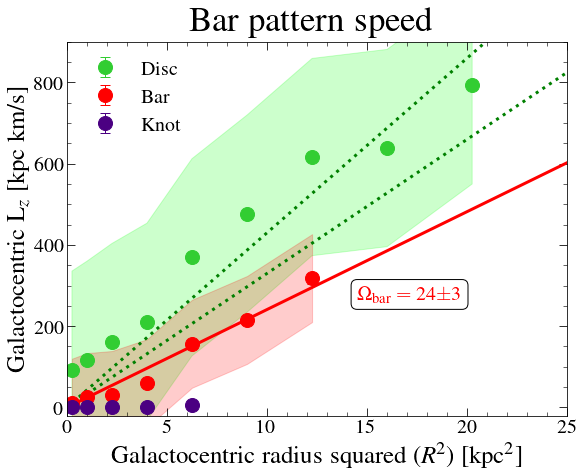

In [40]:
plt.figure(figsize=(8, 6),facecolor='white',constrained_layout=True)

ax1 = plt.subplot(1,1,1)
# ax2 = plt.subplot(2,2,2)
# ax4 = plt.subplot(2,1,2)
axes = [ax1]

plt.figtext(0.32, 1.02,'Bar pattern speed',fontsize=35)

# plt.subplot(2,2,1)
ax1.plot(radios**2,linear(radios**2,33),color='g',lw=3,ls='dotted')
ax1.plot(radios**2,linear(radios**2,43),color='g',lw=3,ls='dotted')

# ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.nanmean(slopes_disc))-scatter_disc,linear(radios2[:-1],np.nanmean(slopes_disc))+scatter_disc,\
#                 alpha=0.2,color='lime')
ax1.fill_between((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1-scatter_disc,lz[mask_disc]*-1+scatter_disc,\
                alpha=0.2,color='lime')
props = dict(boxstyle='round', facecolor='white', alpha=1)
# plt.text(16.5,600, r' '+str("%.0f" % np.nanmean(slopes_disc))+'$\pm0.5$', fontsize=20,
#         verticalalignment='top', bbox=props)
ax1.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [np.abs(lz_min[mask_disc]),lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
# ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.mean(slopes))-scatter_bar,linear(radios2[:-1],np.mean(slopes))+scatter_bar,\
#                 alpha=0.2,color='r')
ax1.fill_between((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1-scatter_bar,lz[mask_bar]*-1+scatter_bar,\
                alpha=0.2,color='r')
ax1.plot(radios**2,linear(radios**2,np.mean(slopes)),color='r',lw=3)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax1.text(14.5,300, r'$\Omega_{\mathrm{bar}} = $ '+str("%.0f" % np.mean(slopes))+'$\pm3$', fontsize=20,
        verticalalignment='top', bbox=props, color='r')
ax1.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [np.abs(lz_min[mask_bar]),lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
ax1.errorbar((data['binmin'][mask_knot]+0.5)**2,lz[mask_knot]*-1,yerr = [np.abs(lz_min[mask_knot]),lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')

ax1.set_xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
ax1.set_ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
ax1.legend(loc='upper left',fontsize=20,frameon=False)
ax1.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax1.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax1.minorticks_on()
# plt.yscale('log')
ax1.set_xlim(0,25)
ax1.set_ylim(-20,900)

# plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/bar-pattern-speed.pdf',dpi=500, bbox_inches = 'tight')


Test for uncertainties in R by fitting the line with the minimum value of R in the bin, instead of the bin centre

(-20.0, 900.0)

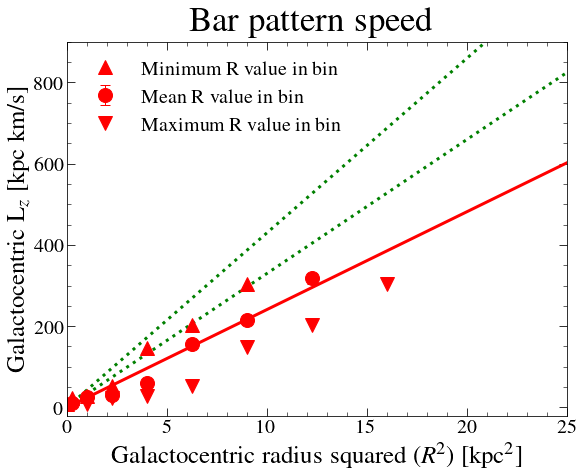

In [41]:
plt.figure(figsize=(8, 6),facecolor='white',constrained_layout=True)

ax1 = plt.subplot(1,1,1)
# ax2 = plt.subplot(2,2,2)
# ax4 = plt.subplot(2,1,2)
axes = [ax1]

plt.figtext(0.32, 1.02,'Bar pattern speed',fontsize=35)

# plt.subplot(2,2,1)
ax1.plot(radios**2,linear(radios**2,33),color='g',lw=3,ls='dotted')
ax1.plot(radios**2,linear(radios**2,43),color='g',lw=3,ls='dotted')

# ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.nanmean(slopes_disc))-scatter_disc,linear(radios2[:-1],np.nanmean(slopes_disc))+scatter_disc,\
#                 alpha=0.2,color='lime')
# props = dict(boxstyle='round', facecolor='white', alpha=1)
# plt.text(16.5,600, r' '+str("%.0f" % np.nanmean(slopes_disc))+'$\pm0.5$', fontsize=20,
#         verticalalignment='top', bbox=props)
# ax1.errorbar((data['binmin'][mask_disc])**2,lz[mask_disc]*-1,yerr = [np.abs(lz_min[mask_disc]),lz_max[mask_disc]],\
#                 fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
# ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.mean(slopes))-scatter_bar,linear(radios2[:-1],np.mean(slopes))+scatter_bar,\
#                 alpha=0.2,color='r')
ax1.plot(radios**2,linear(radios**2,np.mean(slopes)),color='r',lw=3)
props = dict(boxstyle='round', facecolor='white', alpha=1)
# ax1.text(14.5,300, r'$\Omega_{\mathrm{bar}} = $ '+str("%.0f" % np.mean(slopes))+'$\pm3$', fontsize=20,
#         verticalalignment='top', bbox=props, color='r')
ax1.errorbar((data['binmin'][mask_bar])**2,lz[mask_bar]*-1-lz_min[mask_bar]*-1,\
                fmt='^',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Minimum R value in bin')
ax1.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [np.abs(lz_min[mask_bar]),lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Mean R value in bin')
ax1.errorbar((data['binmax'][mask_bar])**2,lz[mask_bar]*-1+lz_max[mask_bar]*-1,\
                fmt='v',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Maximum R value in bin')
# ax1.errorbar((data['binmin'][mask_knot])**2,lz[mask_knot]*-1,yerr = [np.abs(lz_min[mask_knot]),lz_max[mask_knot]],\
#                 fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')

ax1.set_xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
ax1.set_ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
ax1.legend(loc='upper left',fontsize=20,frameon=False)
ax1.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax1.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax1.minorticks_on()
# plt.yscale('log')
ax1.set_xlim(0,25)
ax1.set_ylim(-20,900)

# plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/bar-pattern-speed.pdf',dpi=500, bbox_inches = 'tight')


ValueError: operands could not be broadcast together with shapes (7,) (9,) 

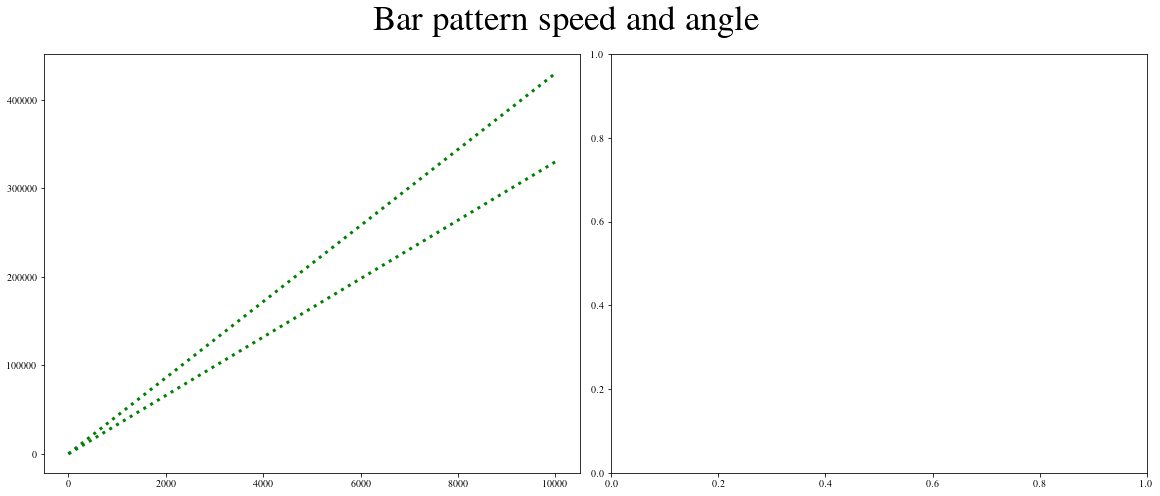

In [42]:
plt.figure(figsize=(16, 12),facecolor='white',constrained_layout=True)

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
# ax4 = plt.subplot(2,1,2)
axes = [ax1, ax2]

plt.figtext(0.32, 1.02,'Bar pattern speed and angle',fontsize=35)

# plt.subplot(2,2,1)
ax1.plot(radios**2,linear(radios**2,33),color='g',lw=3,ls='dotted')
ax1.plot(radios**2,linear(radios**2,43),color='g',lw=3,ls='dotted')

ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.nanmean(slopes_disc))-scatter_disc,linear(radios2[:-1],np.nanmean(slopes_disc))+scatter_disc,\
                alpha=0.2,color='lime')
props = dict(boxstyle='round', facecolor='white', alpha=1)
# plt.text(16.5,600, r' '+str("%.0f" % np.nanmean(slopes_disc))+'$\pm0.5$', fontsize=20,
#         verticalalignment='top', bbox=props)
ax1.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [np.abs(lz_min[mask_disc]),lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.mean(slopes))-scatter_bar,linear(radios2[:-1],np.mean(slopes))+scatter_bar,\
                alpha=0.2,color='r')
ax1.plot(radios**2,linear(radios**2,np.mean(slopes)),color='r',lw=3)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax1.text(14.5,300, r'$\Omega_{\mathrm{bar}} = $ '+str("%.0f" % np.mean(slopes))+'$\pm3$', fontsize=20,
        verticalalignment='top', bbox=props, color='r')
ax1.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [np.abs(lz_min[mask_bar]),lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
ax1.errorbar((data['binmin'][mask_knot]+0.5)**2,lz[mask_knot]*-1,yerr = [np.abs(lz_min[mask_knot]),lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')

ax1.set_xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
ax1.set_ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
ax1.legend(loc='upper left',fontsize=20,frameon=False)
ax1.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax1.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax1.minorticks_on()
# plt.yscale('log')
ax1.set_xlim(0,25)
ax1.set_ylim(-20,900)


# plt.errorbar(data['binmin'][mask_disc]+0.5,angle[mask_disc],yerr = [-angle_min[mask_disc],angle_max[mask_disc]],\
#                 fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc',alpha=0.3)
# ax2.fill_between(np.linspace(0,5,100),20,28,alpha=0.2,color='b',label='Previous bar angle estimates')
ax2.errorbar(data['binmin'][mask_bar]+0.5,angle[mask_bar],yerr = [-angle_min[mask_bar],angle_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
# plt.errorbar(data['binmin'][mask_knot]+0.5,angle[mask_knot],yerr = [-angle_min[mask_knot],angle_max[mask_knot]],\
#                 fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot',alpha=0.3)
# ax2.errorbar(radiuses,angles,yerr = 10,xerr=0.5,\
#                 fmt='s',markersize=14, color='k',ecolor='k', elinewidth=1, capsize=5,label='Gonzalez et al., (2011)',alpha=0.5)
# plt.errorbar(radiuses,angles,c='k',s=200,marker='s',label='Gonzalez et al., (2011)',alpha=0.5)

ax2.set_xlabel(r'Galactocentric radius, $R$ [kpc]',fontsize=25)
ax2.set_ylabel(r'Dynamical angle, $\theta_{\mathrm{bar}}$ [degrees]',fontsize=25)
ax2.legend(loc='upper right',fontsize=20,frameon=False)
ax2.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax2.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax2.minorticks_on()
# plt.yscale('log')
ax2.set_xlim(0,4)
ax2.set_ylim(0,70)

# # plt.subplot(2,2,3)
# ax4.set_title('Resonances in the Milky Way disc',fontsize=35)
# ax4.plot(rads_freq,freqs_eilers,color='gray',lw=3,ls='dotted',label='Eilers et al (2019)')
# ax4.plot(rads_freq,freqs_eilers+(kappas/2),color='k',lw=3,ls='--',label='$\Omega_{\phi}+\kappa/2$')
# ax4.plot(rads_freq,freqs_eilers+(kappas/4),color='darkgray',lw=3,ls='--',label='$\Omega_{\phi}+\kappa/4$')
# # plt.plot(rads_freq,freqs_eilers-(kappas/2),color='k',lw=3,ls='dotted')

# ax4.vlines(9.4,0,200,color='darkorange',alpha=0.6,lw=6)
# ax4.vlines(8.275,0,200,color='cyan',alpha=0.6,lw=6)

# ax4.fill_between(rads_freq,23,25,alpha=0.6,color='r',label='$\Omega_{\mathrm{bar}}=24\pm1$')
# ax4.fill_between(rads_freq,30,45,alpha=0.2,color='b',label='Previous bar pattern speed estimates')
# # plt.fill_between(rads_freq,40,42,alpha=0.6,color='orange')
# ax4.legend(loc='upper right',fontsize=20,frameon=False)


# # plt.vlines(6.87,0,200,color='aquamarine',alpha=0.6,lw=6)
# # plt.text(8.175,9,'$\odot$',fontsize=30)
# # plt.text(6.4,80, r'$R$ = 6.87 kpc', fontsize=18,verticalalignment='top', bbox=props, color='k')
# ax4.text(7.7,80, r'$R_{\odot}$ = 8.275 kpc', fontsize=18,verticalalignment='top', bbox=props, color='k')
# ax4.text(9,80, r'$R_{\mathrm{CR}}$ = 9.4 kpc', fontsize=18,verticalalignment='top', bbox=props, color='k')
# props = dict(boxstyle='round', facecolor='white', alpha=1)
# ax4.set_xlim(5.,15)
# ax4.set_ylim(10,90)
# ax4.set_ylabel(r'Azimuthal frequency, $\Omega_{\phi}$ [km s$^{-s}$ kpc$^{-1}$]',fontsize=22)
# ax4.set_xlabel(r'Galactocentric radius, $R$ [kpc]',fontsize=22)
# ax4.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
# ax4.tick_params(which='minor', length=4, direction='in',top=True,right=True)
# ax4.minorticks_on()
# # plt.yscale('log')

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.3)

plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/bar-measurements-last.pdf',dpi=500, bbox_inches = 'tight')


# Load in the fits to plot x-y projection of the angle change

In [43]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
#     if x.size != y.size:
#         raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [44]:
angles_rads = np.deg2rad(angle)
xs = np.cos(angles_rads[mask_bar])*data['binmin'][mask_bar]
ys = np.sin(angles_rads[mask_bar])*data['binmin'][mask_bar]

radios = np.linspace(-650,650,1001)
xs_angle27 = np.zeros((len(radios)))
ys_angle27 = np.zeros((len(radios)))
for indx, i in enumerate(radios):
    xs_angle27[indx] = np.cos(np.deg2rad(27))*i
    ys_angle27[indx] = np.sin(np.deg2rad(27))*i 
    
radios_sun = np.linspace(-650,650,1001)
xs_sl = np.zeros((len(radios_sun)))
ys_sl = np.zeros((len(radios_sun)))
xs_sl2 = np.zeros((len(radios_sun)))
ys_sl2 = np.zeros((len(radios_sun)))
xs_sl3 = np.zeros((len(radios_sun)))
ys_sl3 = np.zeros((len(radios_sun)))
for indx, i in enumerate(radios_sun):
    xs_sl[indx] = np.cos(np.deg2rad(15))*i
    ys_sl[indx] = np.sin(np.deg2rad(15))*i 
    xs_sl2[indx] = np.cos(np.deg2rad(30))*i
    ys_sl2[indx] = np.sin(np.deg2rad(30))*i 
    xs_sl3[indx] = np.cos(np.deg2rad(45))*i
    ys_sl3[indx] = np.sin(np.deg2rad(45))*i     
    

angles_rads_og = np.deg2rad(angles)
xs_og = np.cos(angles_rads_og)*radiuses
ys_og = np.sin(angles_rads_og)*radiuses

In [45]:
mask_bar1 = (np.array(median_bar_probability)>0.85)&(np.array(std_bar_probability)<0.15)&(R<1.5)&(R>0.5)
mask_bar2 = (np.array(median_bar_probability)>0.85)&(np.array(std_bar_probability)<0.15)&(R>1.5)&(R<2.5)
mask_bar3 = (np.array(median_bar_probability)>0.85)&(np.array(std_bar_probability)<0.15)&(R>2.5)&(R<3.5)


In [46]:
print(-angle_min[mask_disc])
print(angle_max[mask_disc])

[54.  13.3 29.4 12.2 14.2  4.9  3.6  1.6  0.6]
[16.5 12.4 29.  12.9 32.7  5.5  4.6  1.6  0.8]


ValueError: operands could not be broadcast together with shapes (7,) (9,) 

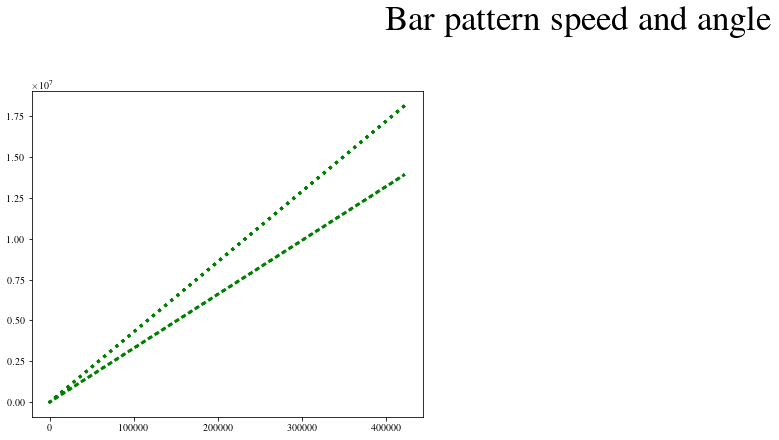

In [47]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(28,6),constrained_layout=True)

plt.figtext(0.3, 1.02,'Bar pattern speed and angle',fontsize=35)


gs = gridspec.GridSpec(6, 7)
gs.update(wspace=0.5,hspace=1)
ax1 = plt.subplot(gs[0:6, :2])

ax1.plot(radios**2,linear(radios**2,33),color='g',lw=3,ls='dotted')
ax1.plot(radios**2,linear(radios**2,43),color='g',lw=3,ls='dotted')

ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.nanmean(slopes_disc))-scatter_disc,linear(radios2[:-1],np.nanmean(slopes_disc))+scatter_disc,\
                alpha=0.2,color='lime')
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax1.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [np.abs(lz_min[mask_disc]),lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
ax1.fill_between(radios2[:-1],linear(radios2[:-1],np.mean(slopes))-scatter_bar,linear(radios2[:-1],np.mean(slopes))+scatter_bar,\
                alpha=0.2,color='r')
ax1.plot(radios**2,linear(radios**2,np.mean(slopes)),color='r',lw=3)
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax1.text(14.5,300, r'$\Omega_{\mathrm{bar}} = $ '+str("%.0f" % np.mean(slopes))+'$\pm3$', fontsize=20,
        verticalalignment='top', bbox=props, color='r')
ax1.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [np.abs(lz_min[mask_bar]),lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
ax1.errorbar((data['binmin'][mask_knot]+0.5)**2,lz[mask_knot]*-1,yerr = [np.abs(lz_min[mask_knot]),lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')

ax1.set_xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
ax1.set_ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
ax1.legend(loc='upper left',fontsize=20,frameon=False)
ax1.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax1.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax1.minorticks_on()
ax1.set_xlim(0,25)
ax1.set_ylim(-20,900)

ax2 = plt.subplot(gs[0:6, 2:4])

# ax2.errorbar(data['binmin'][mask_disc]+0.5,angle[mask_disc],yerr = [-angle_min[mask_disc],angle_max[mask_disc]],\
#                 fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc',alpha=0.4)
ax2.errorbar(data['binmin'][mask_bar]+0.5,angle[mask_bar],yerr = [-angle_min[mask_bar],angle_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
ax2.set_xlabel(r'Galactocentric radius, $R$ [kpc]',fontsize=25)
ax2.set_ylabel(r'Dynamical angle, $\theta_{\mathrm{bar}}$ [degrees]',fontsize=25)
ax2.legend(loc='upper right',fontsize=20,frameon=False)
ax2.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax2.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax2.minorticks_on()
ax2.set_xlim(0,4)
ax2.set_ylim(0,70)
ax2.set_xlabel(r'Galactocentric radius, $R$ [kpc]',fontsize=25)
ax2.set_ylabel(r'Dynamical angle, $\theta_{\mathrm{bar}}$ [degrees]',fontsize=25)
ax2.legend(loc='upper right',fontsize=20,frameon=False)
ax2.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
ax2.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax2.minorticks_on()


ax3 = plt.subplot(gs[0:2, 4:5])
ax3.set_title('$0.5<R<1.5$ kpc',fontsize=14)
ax3.scatter(Lx[mask_bar1],Ly[mask_bar1],s=0.5,c='r',alpha=0.6)
confidence_ellipse(Lx[mask_bar1],Ly[mask_bar1], ax3, n_std=2,
                   label=r'Bar', edgecolor='firebrick',lw=2)
ax3.plot(ys_sl,xs_sl-8.275,color='k',ls='dotted',lw=1)
ax3.plot(-ys_sl,xs_sl-8.275,color='k',ls='dotted',lw=1)
ax3.plot(ys_sl2,xs_sl2-8.275,color='gray',ls='dotted',lw=1)
ax3.plot(-ys_sl2,xs_sl2-8.275,color='gray',ls='dotted',lw=1)
ax3.plot(ys_sl3,xs_sl3-8.275,color='lightgray',ls='dotted',lw=1)
ax3.plot(-ys_sl3,xs_sl3-8.275,color='lightgray',ls='dotted',lw=1)
ax3.set_xlim(-650,650)
ax3.set_ylim(-650,650)
# ax3.set_xlabel(r'L$_{x}$ [kpc km/s]',fontsize=18)
ax3.set_ylabel(r'L$_{y}$ [kpc km/s]',fontsize=16)
ax3.tick_params(which='major',labelsize=10,direction='in',top=True,right=True,length=8)
ax3.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax3.minorticks_on()

ax4 = plt.subplot(gs[2:4, 4:5])
ax4.set_title('$1.5<R<2.5$ kpc',fontsize=14)
ax4.scatter(Lx[mask_bar2],Ly[mask_bar2],s=0.5,c='r',alpha=0.6)
confidence_ellipse(Lx[mask_bar2],Ly[mask_bar2], ax4, n_std=2,
                    edgecolor='firebrick',lw=2)
ax4.plot(ys_sl,xs_sl-8.275,color='k',ls='dotted',lw=1,label='$15^{\circ}$')
ax4.plot(-ys_sl,xs_sl-8.275,color='k',ls='dotted',lw=1)
ax4.plot(ys_sl2,xs_sl2-8.275,color='gray',ls='dotted',lw=1,label='$30^{\circ}$')
ax4.plot(-ys_sl2,xs_sl2-8.275,color='gray',ls='dotted',lw=1)
ax4.plot(ys_sl3,xs_sl3-8.275,color='lightgray',ls='dotted',lw=1,label='$45^{\circ}$')
ax4.plot(-ys_sl3,xs_sl3-8.275,color='lightgray',ls='dotted',lw=1)
ax4.legend(loc='center right',frameon=False,fontsize=10)

ax4.set_xlim(-650,650)
ax4.set_ylim(-650,650)
# ax4.set_xlabel(r'L$_{x}$ [kpc km/s]',fontsize=18)
ax4.set_ylabel(r'L$_{y}$ [kpc km/s]',fontsize=16)
ax4.tick_params(which='major',labelsize=10,direction='in',top=True,right=True,length=8)
ax4.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax4.minorticks_on()

ax5 = plt.subplot(gs[4:6, 4:5])
ax5.set_title('$2.5<R<3.5$ kpc',fontsize=14)
ax5.scatter(Lx[mask_bar3],Ly[mask_bar3],s=0.5,c='r',alpha=0.6)
confidence_ellipse(Lx[mask_bar3],Ly[mask_bar3], ax5, n_std=2,
                    edgecolor='firebrick',lw=2)
ax5.plot(ys_sl,xs_sl-8.275,color='k',ls='dotted',lw=1)
ax5.plot(-ys_sl,xs_sl-8.275,color='k',ls='dotted',lw=1)
ax5.plot(ys_sl2,xs_sl2-8.275,color='gray',ls='dotted',lw=1)
ax5.plot(-ys_sl2,xs_sl2-8.275,color='gray',ls='dotted',lw=1)
ax5.plot(ys_sl3,xs_sl3-8.275,color='lightgray',ls='dotted',lw=1)
ax5.plot(-ys_sl3,xs_sl3-8.275,color='lightgray',ls='dotted',lw=1)

ax5.set_xlim(-650,650)
ax5.set_ylim(-650,650)
ax5.set_xlabel(r'L$_{x}$ [kpc km/s]',fontsize=16)
ax5.set_ylabel(r'L$_{y}$ [kpc km/s]',fontsize=16)
ax5.tick_params(which='major',labelsize=10,direction='in',top=True,right=True,length=8)
ax5.tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax5.minorticks_on()

plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/bar-measurements-ultimo.pdf',dpi=500, bbox_inches = 'tight')


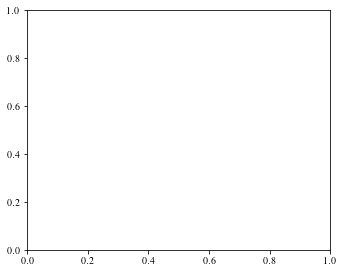

In [48]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(25,15),constrained_layout=True)
gs = gridspec.GridSpec(3, 8)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2])





# Make the angle plot an x-y projection

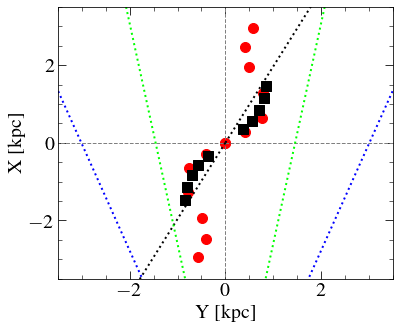

In [49]:
angles_rads = np.deg2rad(angle)
xs = np.cos(angles_rads[mask_bar])*data['binmin'][mask_bar]
ys = np.sin(angles_rads[mask_bar])*data['binmin'][mask_bar]

radios = np.linspace(0.,4,1001)
xs_angle27 = np.zeros((len(radios)))
ys_angle27 = np.zeros((len(radios)))
for indx, i in enumerate(radios):
    xs_angle27[indx] = np.cos(np.deg2rad(27))*i
    ys_angle27[indx] = np.sin(np.deg2rad(27))*i 
    
radios_sun = np.linspace(0.,15,1001)
xs_sl = np.zeros((len(radios_sun)))
ys_sl = np.zeros((len(radios_sun)))
xs_sl2 = np.zeros((len(radios_sun)))
ys_sl2 = np.zeros((len(radios_sun)))
for indx, i in enumerate(radios_sun):
    xs_sl[indx] = np.cos(np.deg2rad(10))*i
    ys_sl[indx] = np.sin(np.deg2rad(10))*i 
    xs_sl2[indx] = np.cos(np.deg2rad(20))*i
    ys_sl2[indx] = np.sin(np.deg2rad(20))*i 
    
    

angles_rads_og = np.deg2rad(angles)
xs_og = np.cos(angles_rads_og)*radiuses
ys_og = np.sin(angles_rads_og)*radiuses

plt.figure(figsize=(6,5),facecolor='white')
plt.vlines(0,-4,4,lw=1,color='gray',ls='dashed')
plt.hlines(0,-4,4,lw=1,color='gray',ls='dashed')
plt.scatter(ys,xs,s=100,c='r')
plt.scatter(-ys,-xs,s=100,c='r')
plt.plot(ys_angle27,xs_angle27,color='k',ls='dotted',lw=2)
plt.plot(-ys_angle27,-xs_angle27,color='k',ls='dotted',lw=2)

plt.plot(ys_sl,xs_sl-8.275,color='lime',ls='dotted',lw=2)
plt.plot(-ys_sl,xs_sl-8.275,color='lime',ls='dotted',lw=2)
plt.plot(ys_sl2,xs_sl2-8.275,color='b',ls='dotted',lw=2)
plt.plot(-ys_sl2,xs_sl2-8.275,color='b',ls='dotted',lw=2)


# plt.text(-0.15,0.,'$\odot$',fontsize=20)
plt.scatter(ys_og,xs_og,s=100,marker='s',c='k')
plt.scatter(-ys_og,-xs_og,s=100,marker='s',c='k')
plt.xlabel('Y [kpc]',fontsize=20)
plt.ylabel('X [kpc]',fontsize=20)
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()


KeyError: 'key of type tuple not found and not a MultiIndex'

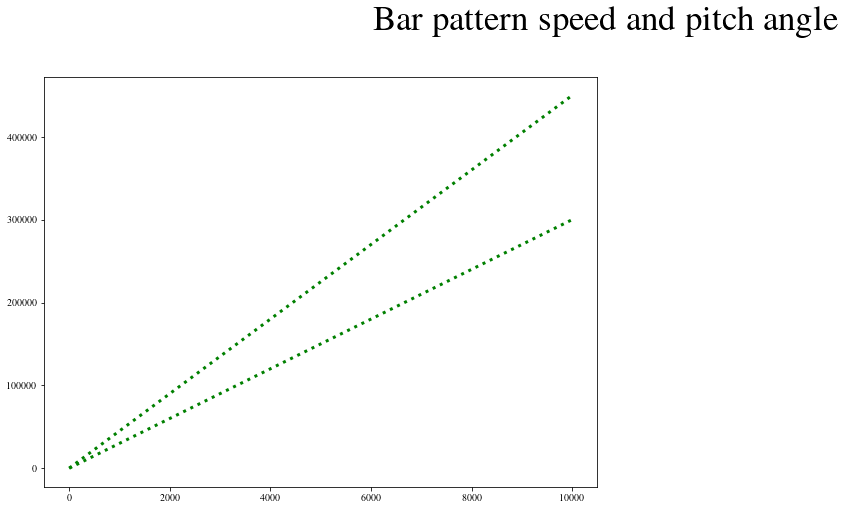

In [193]:
plt.figure(figsize=(16,6),facecolor='white',constrained_layout=True)

plt.figtext(0.32, 1.1,'Bar pattern speed and pitch angle',fontsize=35)
plt.subplot(1,2,1)
plt.plot(radios**2,linear(radios**2,30),color='g',lw=3,ls='dotted')
plt.plot(radios**2,linear(radios**2,45),color='g',lw=3,ls='dotted')

plt.fill_between(radios2[:-1],linear(radios2[:-1],np.nanmean(slopes_disc))-scatter_disc,linear(radios2[:-1],np.nanmean(slopes_disc))+scatter_disc,\
                alpha=0.2,color='lime')
props = dict(boxstyle='round', facecolor='white', alpha=1)
# plt.text(16.5,600, r' '+str("%.0f" % np.nanmean(slopes_disc))+'$\pm0.5$', fontsize=20,
#         verticalalignment='top', bbox=props)
plt.errorbar((data['binmin'][mask_disc]+0.5)**2,lz[mask_disc]*-1,yerr = [lz_min[mask_disc],lz_max[mask_disc]],\
                fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc')
plt.fill_between(radios2[:-1],linear(radios2[:-1],np.mean(slopes))-scatter_bar,linear(radios2[:-1],np.mean(slopes))+scatter_bar,\
                alpha=0.2,color='r')
plt.plot(radios**2,linear(radios**2,np.mean(slopes)),color='r',lw=3)
props = dict(boxstyle='round', facecolor='white', alpha=1)
plt.text(14.5,300, r'$\Omega_{\mathrm{bar}} = $ '+str("%.0f" % np.mean(slopes))+'$\pm3$', fontsize=20,
        verticalalignment='top', bbox=props, color='r')
plt.errorbar((data['binmin'][mask_bar]+0.5)**2,lz[mask_bar]*-1,yerr = [lz_min[mask_bar],lz_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
plt.errorbar((data['binmin'][mask_knot]+0.5)**2,lz[mask_knot]*-1,yerr = [lz_min[mask_knot],lz_max[mask_knot]],\
                fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot')

plt.xlabel(r'Galactocentric radius squared ($R^{2}$) [kpc$^{2}$]',fontsize=25)
plt.ylabel(r'Galactocentric L$_{z}$ [kpc km/s]',fontsize=25)
plt.legend(loc='upper left',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,25)
plt.ylim(-20,900)


plt.subplot(1,2,2)
# plt.errorbar(data['binmin'][mask_disc]+0.5,angle[mask_disc],yerr = [-angle_min[mask_disc],angle_max[mask_disc]],\
#                 fmt='o',markersize=14, color='limegreen',ecolor='limegreen', elinewidth=1, capsize=5,label='Disc',alpha=0.3)
plt.fill_between(np.linspace(0,5,100),20,28,alpha=0.2,color='b',label='Previous bar angle estimates')
plt.errorbar(data['binmin'][mask_bar]+0.5,angle[mask_bar],yerr = [-angle_min[mask_bar],angle_max[mask_bar]],\
                fmt='o',markersize=14, color='r',ecolor='r', elinewidth=1, capsize=5,label='Bar')
# plt.errorbar(data['binmin'][mask_knot]+0.5,angle[mask_knot],yerr = [-angle_min[mask_knot],angle_max[mask_knot]],\
#                 fmt='o',markersize=14, color='indigo',ecolor='indigo', elinewidth=1, capsize=5,label='Knot',alpha=0.3)
plt.errorbar(radiuses,angles,yerr = 10,xerr=0.5,\
                fmt='s',markersize=14, color='k',ecolor='k', elinewidth=1, capsize=5,label='Gonzalez et al., (2011)',alpha=0.5)
# plt.errorbar(radiuses,angles,c='k',s=200,marker='s',label='Gonzalez et al., (2011)',alpha=0.5)

plt.xlabel(r'Galactocentric radius, $R$ [kpc]',fontsize=25)
plt.ylabel(r'Pitch angle [degrees]',fontsize=25)
plt.legend(loc='upper right',fontsize=20,frameon=False)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')
plt.xlim(0,5)
plt.ylim(0,70)

plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/bar-pattern.pdf',dpi=500,fmt='pdf', bbox_inches = 'tight')



In [50]:
rads_freq = np.linspace(5.,30.,1001)
freqs_eilers = np.zeros((len(rads_freq)))
freqs_reid = np.zeros((len(rads_freq)))

for indx, i in enumerate(rads_freq):
    freqs_eilers[indx] = (229.0-(1.7*(i-8.275)))/i

vcirc_eilers = np.zeros((len(rads_freq)))
for indx, i in enumerate(rads_freq):
    vcirc_eilers[indx] = (229.0-(1.7*(i-8.275)))
    
for indx, i in enumerate(rads_freq):
    freqs_reid[indx] = (236.0)/i

vcirc_reid = np.zeros((len(rads_freq)))
for indx, i in enumerate(rads_freq):
    vcirc_reid[indx] = (236.0)


In [51]:
diffs = np.ediff1d(freqs_eilers**2,to_end=0)
omega_rads = diffs/(rads_freq[1]-rads_freq[0])

diffs2 = np.ediff1d(freqs_reid**2,to_end=0)
omega_rads2 = diffs2/(rads_freq[1]-rads_freq[0])

In [52]:
# kappas = np.sqrt(4*freqs_eilers**2*(1+1/2*(rads_freq/freqs_eilers*omega_rads)))
kappas = np.sqrt(4*freqs_eilers**2+(rads_freq*omega_rads))
kappas2 = np.sqrt(4*freqs_reid**2+(rads_freq*omega_rads2))

In [83]:
print(freqs_eilers[(freqs_eilers>23.96)&(freqs_eilers<24.05)])
print(rads_freq[(freqs_eilers>23.96)&(freqs_eilers<24.05)])
print(rads_freq[(freqs_reid>23.96)&(freqs_reid<24.05)])

print(rads_freq[((freqs_eilers-(kappas/4))>23.96)&((freqs_eilers-(kappas/4))<24.05)])
print(rads_freq[((freqs_reid-(kappas/4))>23.96)&((freqs_reid-(kappas/4))<24.05)])


[24.02142857]
[9.45]
[9.825]
[6.325]
[6.475]


In [93]:
#lower uncertainty
print(freqs_eilers[(freqs_eilers>20.97)&(freqs_eilers<21.05)])
print(freqs_reid[(freqs_reid>20.98)&(freqs_reid<21.05)])

print(rads_freq[(freqs_eilers>20.97)&(freqs_eilers<21.05)])
print(rads_freq[(freqs_reid>20.98)&(freqs_reid<21.05)])

print(rads_freq[((freqs_eilers-(kappas/4))>20.97)&((freqs_eilers-(kappas/4))<21.05)])
print(rads_freq[((freqs_reid-(kappas/4))>20.98)&((freqs_reid-(kappas/4))<21.05)])


[21.01658879]
[21.02449889]
[10.7]
[11.225]
[7.2]
[7.45]


In [101]:
#upper uncertainty
print(freqs_eilers[(freqs_eilers>26.97)&(freqs_eilers<27.05)])
print(freqs_reid[(freqs_reid>26.98)&(freqs_reid<27.05)])

print(rads_freq[(freqs_eilers>26.97)&(freqs_eilers<27.05)])
print(rads_freq[(freqs_reid>26.98)&(freqs_reid<27.05)])

print(rads_freq[((freqs_eilers-(kappas/4))>26.95)&((freqs_eilers-(kappas/4))<27.05)])
print(rads_freq[((freqs_reid-(kappas/4))>26.95)&((freqs_reid-(kappas/4))<27.05)])


[26.98053097]
[27.0487106]
[8.475]
[8.725]
[5.65]
[5.75]


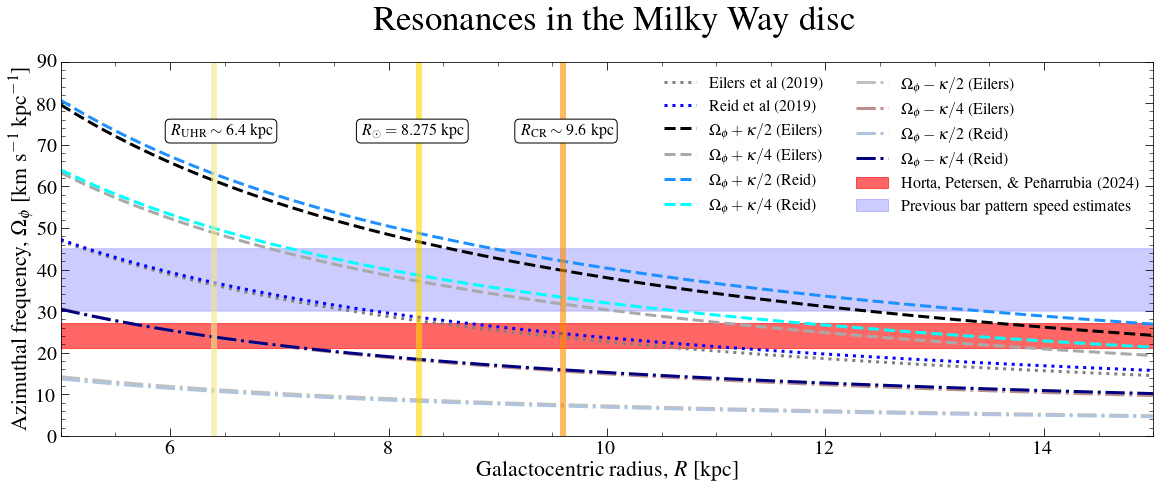

In [99]:
plt.figure(figsize=(16,6),facecolor='white',constrained_layout=True)

props = dict(boxstyle='round', facecolor='white', alpha=1)

plt.figtext(0.32, 1.05,'Resonances in the Milky Way disc',fontsize=35)
plt.plot(rads_freq,freqs_eilers,color='gray',lw=3,ls='dotted',label='Eilers et al (2019)')
plt.plot(rads_freq,freqs_reid,color='b',lw=3,ls='dotted',label='Reid et al (2019)')
plt.plot(rads_freq,freqs_eilers+(kappas/2),color='k',lw=3,ls='--',label='$\Omega_{\phi}+\kappa/2$ (Eilers)')
plt.plot(rads_freq,freqs_eilers+(kappas/4),color='darkgray',lw=3,ls='--',label='$\Omega_{\phi}+\kappa/4$ (Eilers)')
plt.plot(rads_freq,freqs_reid+(kappas2/2),color='dodgerblue',lw=3,ls='--',label='$\Omega_{\phi}+\kappa/2$ (Reid)')
plt.plot(rads_freq,freqs_reid+(kappas2/4),color='cyan',lw=3,ls='--',label='$\Omega_{\phi}+\kappa/4$ (Reid)')

plt.plot(rads_freq,freqs_eilers-(kappas/2),color='silver',lw=3,ls='-.',label='$\Omega_{\phi}-\kappa/2$ (Eilers)')
plt.plot(rads_freq,freqs_eilers-(kappas/4),color='rosybrown',lw=3,ls='-.',label='$\Omega_{\phi}-\kappa/4$ (Eilers)')
plt.plot(rads_freq,freqs_reid-(kappas2/2),color='lightsteelblue',lw=3,ls='-.',label='$\Omega_{\phi}-\kappa/2$ (Reid)')
plt.plot(rads_freq,freqs_reid-(kappas2/4),color='navy',lw=3,ls='-.',label='$\Omega_{\phi}-\kappa/4$ (Reid)')
# plt.plot(rads_freq,freqs_eilers-(kappas/2),color='k',lw=3,ls='dotted')

plt.vlines(9.6,0,200,color='darkorange',alpha=0.6,lw=6)
plt.vlines(8.275,0,200,color='gold',alpha=0.6,lw=6)
plt.vlines(6.4,0,200,color='khaki',alpha=0.6,lw=6)

plt.fill_between(rads_freq,21,27,alpha=0.6,color='r',label='Horta, Petersen, $\&$ Pe\~narrubia (2024)')
plt.fill_between(rads_freq,30,45,alpha=0.2,color='b',label='Previous bar pattern speed estimates')
# plt.fill_between(rads_freq,40,42,alpha=0.6,color='orange')
plt.legend(loc='upper right',fontsize=16,frameon=False,ncols=2)


# plt.vlines(6.87,0,200,color='aquamarine',alpha=0.6,lw=6)
# plt.text(8.175,9,'$\odot$',fontsize=30)
# plt.text(6.4,80, r'$R$ = 6.87 kpc', fontsize=18,verticalalignment='top', bbox=props, color='k')
plt.text(7.75,75, r'$R_{\odot} = 8.275$ kpc', fontsize=16,verticalalignment='top', bbox=props, color='k')
plt.text(9.2,75, r'$R_{\mathrm{CR}} \sim 9.6$ kpc', fontsize=16,verticalalignment='top', bbox=props, color='k')
plt.text(6.,75, r'$R_{\mathrm{UHR}} \sim 6.4$ kpc', fontsize=16,verticalalignment='top', bbox=props, color='k')
plt.xlim(5.,15)
plt.ylim(0,90)
plt.ylabel(r'Azimuthal frequency, $\Omega_{\phi}$ [km s$^{-1}$ kpc$^{-1}$]',fontsize=22)
plt.xlabel(r'Galactocentric radius, $R$ [kpc]',fontsize=22)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
# plt.yscale('log')

plt.savefig('/Users/dhortadarrington/Documents/Projects/mw-bar/plots-paper/bar-resonances-mnras.pdf',dpi=500, bbox_inches = 'tight')


# Fit the bar pattern speed adding statistical uncertainty

In [180]:
# load the classification data
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
median_knot_probability = []
median_bar_probability = []
median_disc_probability = []
std_knot_probability = []
std_bar_probability = []
std_disc_probability = []
all_knot_probability = []
all_bar_probability = []
all_disc_probability = []
RxyzL = []


for key in tqdm.tqdm_notebook(f.keys()):
    median_knot_probability.append(np.nanmedian(f[key][:,2]))
    median_bar_probability.append(np.nanmedian(f[key][:,1]))
    median_disc_probability.append(np.nanmedian(f[key][:,0]))
    std_knot_probability.append(np.nanstd(f[key][:,2]))
    std_bar_probability.append(np.nanstd(f[key][:,1]))
    std_disc_probability.append(np.nanstd(f[key][:,0]))
    all_knot_probability.append((f[key][:,2]))
    all_bar_probability.append((f[key][:,1]))
    all_disc_probability.append((f[key][:,0]))
    RxyzL.append(f[key][:,3][:12])
f.close() # don't forget to close the file!

  0%|          | 0/32489 [00:00<?, ?it/s]

In [181]:
mask_knot2 = (np.array(median_knot_probability)>0.8)&(np.array(std_knot_probability)<0.15)
mask_bar2 = (np.array(median_bar_probability)>0.8)&(np.array(std_bar_probability)<0.15)
mask_disc2 = (np.array(median_disc_probability)>0.8)&(np.array(std_disc_probability)<0.15)
RxyzL_ = np.array(RxyzL)
R = RxyzL_[:,0]
x = RxyzL_[:,1]
y = RxyzL_[:,2]
z = RxyzL_[:,3]
Lx = RxyzL_[:,4]
Ly = RxyzL_[:,5]
Lz = RxyzL_[:,6]
vx = RxyzL_[:,7]
vy = RxyzL_[:,8]
vz = RxyzL_[:,9]
eR = RxyzL_[:,10]
eLz = RxyzL_[:,11]

# find the median bar radius per bin per classification
radvals = np.zeros(4) # we know there are four independent bins with bar classifications
criteria = (R>0) & (R<1)
radvals[0] = np.nansum(R[criteria]*np.array(median_bar_probability)[criteria])/np.nansum(np.array(median_bar_probability)[criteria])

criteria = (R>1) & (R<2)
radvals[1] = np.nansum(R[criteria]*np.array(median_bar_probability)[criteria])/np.nansum(np.array(median_bar_probability)[criteria])

criteria = (R>2) & (R<3)
radvals[2] = np.nansum(R[criteria]*np.array(median_bar_probability)[criteria])/np.nansum(np.array(median_bar_probability)[criteria])

criteria = (R>3) & (R<4)
radvals[3] = np.nansum(R[criteria]*np.array(median_bar_probability)[criteria])/np.nansum(np.array(median_bar_probability)[criteria])

In [192]:
import pandas as pd

# load the csv data, but only the independent bins!
data = pd.read_csv('/Users/dhortadarrington/Documents/Projects/mw-bar/data/table_independent1.csv')

mask_disc = np.where(data['comp']=='disc')
mask_knot = np.where(data['comp']=='knot')
mask_bar = np.where(data['comp']=='bar')


# we're just fitting a linear model, no intercept.
def func(x,a):
    return a*x

popt, pcov = curve_fit(func, (radvals)**2, -1*data['Lz'].values[mask_bar],sigma=data['sigmaz'].values[mask_bar])

print('The pattern speed is {0}pm{1}'.format(popt,np.sqrt(pcov[0])))


The pattern speed is [23.64855232]pm[3.12496666]
